## Please upvote if you like it ;)

# Import Modules

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import h5py
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from keras.regularizers import l2
from keras import optimizers
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

Using TensorFlow backend.


# Make Data

In [2]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('../input/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'05_thumb': 0,
 '08_palm_moved': 1,
 '03_fist': 2,
 '09_c': 3,
 '04_fist_moved': 4,
 '01_palm': 5,
 '10_down': 6,
 '06_index': 7,
 '07_ok': 8,
 '02_l': 9}

In [3]:
x_data = []
y_data = []
IMG_SIZE = 150
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0,10): # Loop over the ten top-level folders
    for j in os.listdir('../input/leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('../input/leapgestrecog/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                path = '../input/leapgestrecog/leapGestRecog/0' + str(i) + '/' + j + '/' + k
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

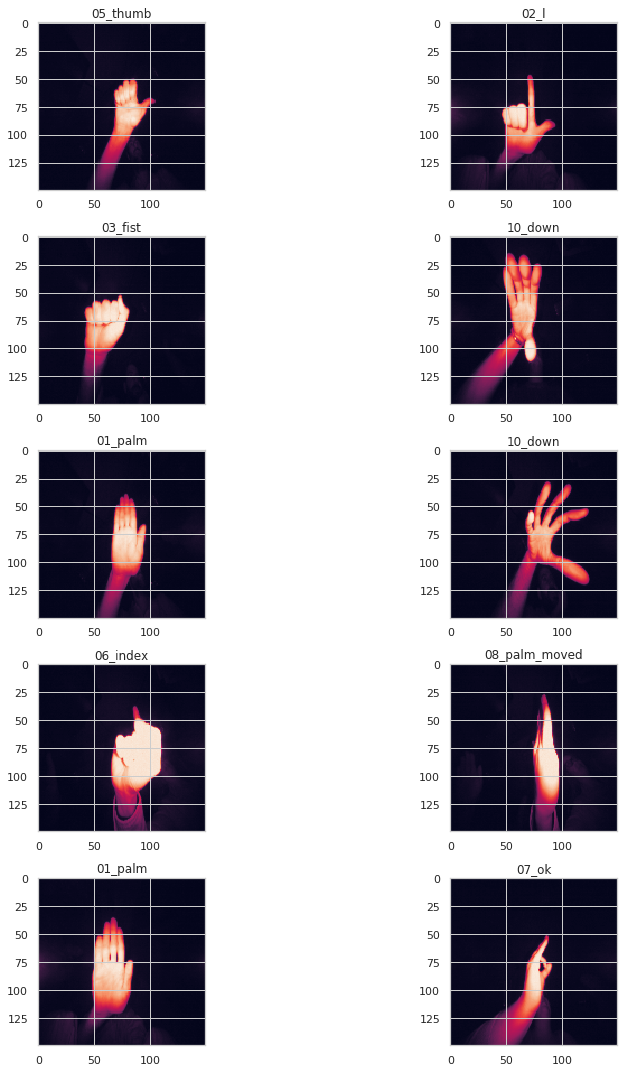

In [4]:
# check some image
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(y_data))
        ax[i,j].imshow(x_data[l])
        ax[i,j].set_title(reverselookup[y_data[l,0]])
        
plt.tight_layout()

In [5]:
y_data=to_categorical(y_data)
x_data = x_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
x_data = x_data/255

In [6]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.6,random_state=42)

# Model Build

In [7]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =32, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10, activation = "softmax"))

In [8]:
batch_size=128
epochs=10

In [9]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [10]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 96)        83040     
__________

# Train

In [12]:
History = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test),callbacks=callbacks)

Train on 8000 samples, validate on 12000 samples
Epoch 1/10
8000/8000 [==============================] - 11s 1ms/step - loss: 0.5754 - acc: 0.8156 - val_loss: 0.0749 - val_acc: 0.9807

Epoch 00001: val_loss improved from inf to 0.07490, saving model to ./base.model
Epoch 2/10
8000/8000 [==============================] - 7s 882us/step - loss: 0.0252 - acc: 0.9929 - val_loss: 0.0361 - val_acc: 0.9838

Epoch 00002: val_loss improved from 0.07490 to 0.03608, saving model to ./base.model
Epoch 3/10
8000/8000 [==============================] - 7s 863us/step - loss: 0.0104 - acc: 0.9966 - val_loss: 0.0063 - val_acc: 0.9987

Epoch 00003: val_loss improved from 0.03608 to 0.00634, saving model to ./base.model
Epoch 4/10
8000/8000 [==============================] - 7s 870us/step - loss: 0.0192 - acc: 0.9961 - val_loss: 0.0077 - val_acc: 0.9983

Epoch 00004: val_loss did not improve from 0.00634
Epoch 5/10
8000/8000 [==============================] - 7s 861us/step - loss: 0.0015 - acc: 0.9995 - v

# Check Result

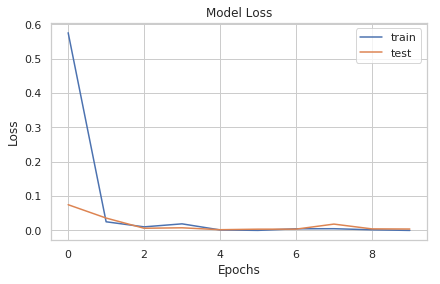

In [13]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

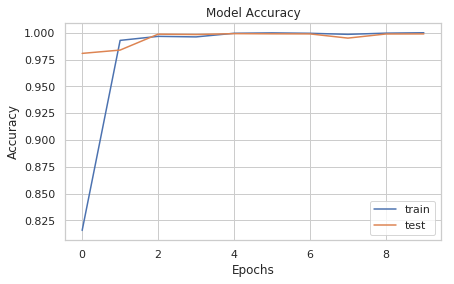

In [14]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## Please upvote if you like it;)

In [15]:
model.save('model.h5')